## Import Required Libaries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import mutual_info_regression

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from tensorflow import keras
from tensorflow.keras import layers

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

## Import File from CSV

In [ ]:
df = pd.read_csv('/kaggle/input/predict-survival-of-patients-with-heart-failure/heart_failure_clinical_records_dataset.csv')

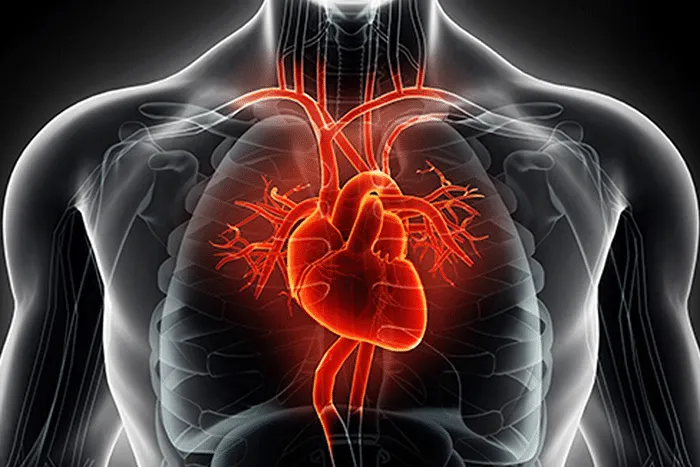

**If you find this notebook helpful, please consider upvoting it or leaving a comment. ❤️**

# About Dataset

This dataset contains the medical records of 299 patients who had heart failure, collected during their follow-up period, where each patient profile has 13 clinical features.

Dataset Characteristics: Multivariate

Subject Area: Health and Medicine

Associated Tasks: Classification, Regression, Clustering

Feature Type: Integer, Real

Instances: 299

Features: 12

**Dataset Information**
A detailed description of the dataset can be found in the Dataset section of the following paper:

**Title:**
Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone

Authors:

Davide Chicco
Giuseppe Jurman
Source:
BMC Medical Informatics and Decision Making 20, 16 (2020)

DOI:
https://doi.org/10.1186/s12911-020-1023-5

# 1.  Exploratory Data Analysis

## 1.1 Dataset Information

Let's start by examining some statistics about the dataset we are working with.

**Objective:** Predict the Survival of patients with heart failure
* DEATH_EVENT is the target variable we are trying to predict. It is boolean.
    * 1 = death 
    * 0 = survival
  
**Dataset Overview:**
* Medical records of 299 heart failure patients collected at Faisalabad Institute of Cardiology and Allied Hospital in Faisalabad, Punjab, Pakistan, during April–December 2015.
* Patients had left ventricular systolic dysfunction and were classified as NYHA classes III or IV.
* Consisted of 105 women and 194 men, aged between 40 and 95 years old.

**Features:**
* 13 features including clinical, body, and lifestyle information.
* Binary features: anaemia, high blood pressure, diabetes, sex, and smoking.
* Anaemia defined as haematocrit levels lower than 36%.
* Definition of high blood pressure not provided in the dataset.
* Creatinine phosphokinase (CPK) indicates the level of CPK enzyme in blood, possibly indicating heart failure or injury with high levels.
* Ejection fraction measures the percentage of blood pumped out by the left ventricle with each contraction.
* Serum creatinine indicates kidney function; high levels may suggest renal dysfunction.
* Serum sodium test checks sodium levels in the blood, abnormal levels may indicate heart failure.
* Death event feature used as target in binary classification study, indicating if the patient died or survived during the follow-up period (130 days on average).

**Dataset Characteristics:**
* Dataset represented as a table with 299 rows (patients) and 13 columns (features).
* Imbalance in the dataset with 203 survived patients and 96 dead patients.
* Survival rate: 67.89% negatives (survived), 32.11% positives (died).
* Further details and changes to feature names available in the original dataset curator's publication.

## 1.2 Summary Statistics

Let's look at the top 5 rows of the dataframe to get a quick sense of the data.

In [ ]:
# Display the top 5 rows of the dataframe
df.head()

In [ ]:
# Display the shape of the dataframe 
print('The shape of the dataframe is:')
df.shape

Let's take a look at the datatypes contained within this dataframe.

In [ ]:
# Display info about the dataframe such as column non-null count and Dtype
df.info()

In [ ]:
# Describe the dataframe
df.describe()

Above is the description of the dataframe. There are 299 patients in this dataset. We can see some interesting information already, for example:
* The average age of patients was 60.8
* 43% of patients are anaemic 
* 42% of patients have diabetes
* 35% of patients have high blood pressure
* 32% of patients are smokers
* 65% of patients are men

The other categories are not significant to me yet, mostly because I do not have a medical background. We will still explore if these features are correlated to survival of patients with heart failure.

From a cursory glance at the above bullet-points, I suspect they may be correlated to survival rates. I want to visualize each of these with a plot before proceeding to see how they look.  





## 1.3 Exploratory Data Visualization

In [ ]:
# Plot the age of patients in the dataframe
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', bins=28, kde=True, color='seagreen')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age')
plt.show()

We know from the description of the dataset that the average age of patients is 60. We can also tell that most patients in this dataset were between age 45 and 70, suggesting that age might be correlated with heart failure. We can also see that the highest number of patients in this dataset were aged 60. Let's look at some other columns that I suspect might be correlated with survival rates of patients with heart failure.

In [ ]:
sns.displot(data=df, bins=2, x='anaemia', hue='anaemia', palette='rainbow', legend=False)
plt.xlabel('Anaemic/Not Anaemic')
plt.ylabel('Count')
plt.title('Distribution of Anaemic Patients')
plt.legend(title='Anaemia', labels=['Yes', 'No'])
plt.show()

We can visualize that almost half of the patients are anaemic. The Institute for Health Metrics and Evaluation estimates that approximately one-fourth of the global population is anemic. In this dataset, there appears to be a high proportion of anaemic patients.

In [ ]:
sns.displot(data=df, bins=2, x='smoking', hue='smoking', palette='rocket', legend=False)
plt.xlabel('Smoker/Non-Smoker')
plt.ylabel('Count')
plt.title('Distribution of Smokers')
plt.legend(title='Smoking', labels=['Yes', 'No'])
plt.show()

We can see that roughly 2/3 of the patients in the dataset were non-smokers, while almost 1/3 of the patients were smokers. I assume that smoking is correlated with heart failure, but we will examine how closely related they are later. I searched to determine what percentage of Pakistani people smoke tobacco (this dataset is from Pakison) an estimate from Population Health Metrics suggests that approximately 20% of people in Pakistan smoke. This dataset seems to have a disproportionately high number of smokers. 

In [ ]:
sns.displot(data=df, bins=2, x='diabetes', hue='diabetes', palette='YlOrBr', legend=False)
plt.xlabel('Diabetic/Non-Diabetic')
plt.ylabel('Count')
plt.title('Distribution of Diabetic Patients')
plt.legend(title='Diabetic', labels=['Yes', 'No'])
plt.show()

Again we find something meaningful. Almost half of the patients are diabetic. We can hypothesize that diabetes might be correlated with heart failure. According to the National Institute of Health, approximately 26.7% of adults in Pakistan are diabetic. Once again, we see a large number of diabetic people in this dataset when compared to the general population.

In [ ]:
sns.displot(data=df, bins=2, x='high_blood_pressure', hue='high_blood_pressure', palette='pastel', legend=False)
plt.xlabel('Blood Pressure')
plt.ylabel('Count')
plt.title('Distribution of Patients with High Blood Pressure')
plt.legend(title='High Blood Pressure', labels=['Yes', 'No'])
plt.show()

Similar to the other histograms, we can observe that 1/3 of patients with heart failure symptoms experience high blood pressure. The National Institutes of Health suggest that according to the last population-based National Health Survey of Pakistan (NHSP), nearly 18.9% of people in Pakistan above 15 years were hypertensive, with a higher prevalence in urban populations than rural population, and in men more than women. In our dataset, 35% of people have high blood pressure, nearly double the national average.

In [ ]:
sns.displot(data=df, bins=2, x='sex', hue='sex', palette='cubehelix_r', legend=False)
plt.xlabel('Sex (Male/Female)')
plt.ylabel('Count')
plt.title('Distribution of Men and Women')
plt.legend(title='Sex', labels=['Male', 'Female'])
plt.show()

It seems somewhat remarkable that 65% of patients are men. Worldbank open data sets suggest that men represent approximately 50% of Pakistan's population. It seems that more men suffer from heart failure than women, at least in this particular dataset.

### Comparison of Features
Let's look at how these 5 variables affect the patients in our dataset when compared to age.

In [ ]:
# Create a figure and axes with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot the distribution of anaemic
sns.histplot(data=df, x='age', bins=7, hue='anaemia', palette='rainbow', multiple='stack', ax=axes[0, 0])
axes[0, 0].set_xlabel('Anaemic/Not Anaemic')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution of Anaemic Patients')

# Plot the distribution of smokers
sns.histplot(data=df, x='age', bins=7, hue='smoking', palette='rocket', multiple='stack', ax=axes[0, 1])
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Distribution of Smokers')

# Plot the distribution of diabetic
sns.histplot(data=df, x='age', bins=7, hue='diabetes', palette='YlOrBr', multiple='stack', ax=axes[0, 2])
axes[0, 2].set_xlabel('Age')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Distribution of Diabetes')

# Plot the distribution of high blood pressure
sns.histplot(data=df, x='age', bins=7, hue='high_blood_pressure', palette='pastel', multiple='stack', ax=axes[1, 0])
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Distribution of Blood Pressure')

# Plot the distribution of men/women
sns.histplot(data=df, x='age', bins=7, hue='sex', palette='cubehelix_r', multiple='stack', ax=axes[1, 1])
axes[1, 1].set_xlabel('Sex (Male/Female)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Distribution of Men and Women')

# Remove the empty 6th subplot
fig.delaxes(axes[1, 2])

# Adjust layout
plt.tight_layout()
plt.show()

I'm quite satisfied with this preliminary data analysis. Looking at the charts at a glance, we can see that there are a lot of smokers, diabetics, and people with high-blood pressure in the dataset. I suspected initially that there could be a significant correlation between these categories and survival rate after heart failure. The next thing that I want to do is take a look at the other columns in our dataset.

In [ ]:
df.hist(figsize=(20,10),bins=7, color='seagreen')

At a glance this offers some further insight into how we might engineer features for our model. 


For example, I can tell quickly that the following features will be categorical:
* DEATH_EVENT - No/Yes (This is what we are trying to predict with our model)
* anaemia - No/Yes
* high_blood_pressure - No/Yes
* sex - Female/Male
* smoking - No/Yes
* diabetes - No/Yes


The remaining features are numerical:
* age
* ejection_fraction
* serum_sodium
* creatine_phosphokinase
* platelets
* serum_creatinine
* time

### Target Distribution

How many patients were dead by their next checkup? Let's look into this a little bit. 

In [ ]:
sns.displot(data=df, bins=2, x='DEATH_EVENT', hue='DEATH_EVENT', palette='CMRmap_r', legend=False)
plt.xlabel('Dead/Alive')
plt.ylabel('Count')
plt.title('Distribution of Survival Rate')
plt.legend(title='Alive', labels=['No', 'Yes'])
plt.show()

This chart is quite telling. Of the 299 patients where data was collected:
* 68% (203 patients) were alive when the hospital followed up with them after heart failure
* 32% (96 patients) were dead when the hospital followed up with them after heart failure

### Survival Rates Over Time

One question I have is related to the time column. We know that this column varies quite a bit in the dataset. How is the timing of the next checkup related to the DEATH_EVENT outcome (dead/alive)?

Let's plot this out and see. 

In [ ]:
# Plot the time column in relation to DEATH_EVENT
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='time', hue='DEATH_EVENT', bins=28, multiple='stack', palette='CMRmap_r')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Distribution of Survival Rate in Comparison to Time')
plt.legend(title='Alive', labels=['No', 'Yes'])
plt.show()

This chart is interesting to me, because it is something I did not expect. What this shows is that the longer the follow-up period, the fewer patients who died.

*Essentially, the patients who experienced heart failure and were not dead within approximately 75 days were more likely to be alive.*

Time of follow-up period is highly correlated with 'DEATH_EVENT'. 

## 1.4 Correlation Among Features

Before I move onto building my model and making a prediction, I want to look closely at the correlation among features in this dataset.

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot = True, cmap = "coolwarm")
plt.title('The correlation among features',y= 1.05)
plt.show()

The features most correlated to DEATH_EVENT are:
* time
* serum_sodium
* serum_creatinine
* ejection_fraction
* age

Let's talk about the 'time' feature for a moment. Data scientist Rabie El Kharoua has pointed out that 'time' should not be used as a feature due to the following:
* "End Users Can't Predict Time: Think about it: when we deploy our models, the folks using them won't know when in the future a patient might die or get censored. So, relying on the "time" column for predictions wouldn't make sense, right?"

For this reason I have pre-emptively removed 'time' as a feature in the model.

Some features mildly correlated to DEATH_EVENT are:
* anaemia
* creatinine_phosphokinase
* high_blood_pressure
* platelets
* smoking

While there are substantially more men than women in the dataset - which perhaps reflects a higher chance of heart failure - sex does not appear to be correlated to survival rate. The presence of diabetes is also not strongly correlated.

I'll go out on a limb here and say that my lack of knowledge in regards to medical terminology might have affected my initial hypothesis a bit. I have to do some research to understand the effects of serum_sodium, serum_creatinine, and ejection_fraction on survival rates after heart failure. Time is not surprising to me, although the inverse relationship to DEATH_EVENT was interesting. Age is something I correctly guessed might be correlated. 

# 2. Model Building and Evaluation

## 2.1 Feature PreProcessing and Splitting the Dataset

At this point I am ready to build a machine learning model with the end goal of making predictions for survival rate. In order to do that I have to split my data into a training and testing set. I will compare the results from my classification model with the test set and see how accurate or inaccurate the model is before I try to improve upon it.

In [ ]:
X = df.drop(columns=['time'])
y = X.pop('DEATH_EVENT')

features_num = [
    'age', 'ejection_fraction', 'serum_sodium', 'serum_creatinine', 'creatinine_phosphokinase', 'platelets',
]

features_cat = [
    'smoking', 'high_blood_pressure', 'anaemia',
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"),
    StandardScaler(),
)

transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant"),
    OneHotEncoder(),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75, random_state=42)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

## 2.2 Feature Engineering

### Mutual Information of Features

At this point I'm going to look into the features that I visualized above and determine which are most correlated with the 'DEATH_EVENT' column. Recall we drop the 'time' column as a feature so we cannot determine mutual information from it, although we can assume it is highly correlated with 'DEATH_EVENT'.

In [ ]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)
mi_scores[::]  # show a few features with their MI scores

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores, color='seagreen')
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

We can see from the mutual information plot that sex, platelets, high_blood_pressure, and anaemia might not be as useful to our model as the other features.

## 2.3 Choosing a Model

Recall that our goal is to predict the survival or death of patients with heart failure. For this task we can use a binary classification model. Some information about binary classification follows:

* Classification into one of two classes is a common machine learning problem. You might want to predict whether or not a customer is likely to make a purchase, whether or not a credit card transaction was fraudulent, whether deep space signals show evidence of a new planet, or a medical test evidence of a disease. These are all binary classification problems.

For this task, I'll start by importing tensorflow and setting up a neural network.

In [ ]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(1, activation='sigmoid'),
    ])

We can define the model just like we do for regression tasks, with one exception. In the final layer include a 'sigmoid' activation so that the model will produce class probabilities. Add the cross-entropy loss and accuracy metric to the model with its compile method. For two-class problems, be sure to use 'binary' versions. The 'Adam' optimizer works great for classification, so let's start with that.

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

## 2.4 Making a Prediction

Now the exciting part. We've selected a model and chosen our features. We'll set a parameter to stop the model if it doesn't improve within a certain threshold (I've chosen 10 epochs), and then we will fit our model to the training and validation data and make a prediction.

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=299,
    epochs=300,
    callbacks=[early_stopping],
    verbose=0,
)

## 2.5 Evaluating the Model

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

**The selected model was 76% accurate in predicting the survival of patients with heart failure.** 

Recall that this was a relatively small dataset (299 patients) and I am genuinely curious if the model would improve with a larger dataset.

For this task, I am quite satisfied with the accuracy of the binary classification model selected. While not applicable to many machine learning tasks, this model is effective at predicting whether a patient will survive or die after suffering heart failure with the features from this dataset.

# 3. Conclusion

* For this dataset, a binary classification model is an effective way to predict the survival of patients with heart failure

* A random forest model could also be effective in making this prediction

* Although clearly correlated to 'DEATH_EVENT', the 'time' feature should be not used because time is a target, not a feature

* The most important features for this model are:                  
    * ejection_fraction           
    * age                         
    * serum_creatinine           
    * serum_sodium                
    * creatinine_phosphokinase   
    * diabetes                    
    * smoking
    
* Features that were less important in increasing the accuracy of the model are:
    * anaemia                   
    * high_blood_pressure        
    * platelets                  
    * sex                         
    
* The model we chose predicted the survival of patients with heart failure at 76% accuracy when compared to the validation dataset